In [1]:
# graph neural network 
import intel_npu_acceleration_library

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree


import torch
from torch import tensor
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, Linear, GraphConv

from nb_functions import find_filtered_voronoi_neighbor_knn_limited_mask

c:\ProgramData\miniconda3\envs\drosophila\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
positions = np.load('quarters/positions.npy')
print(positions.shape)

# load data

data = []
for i in range(4):
    for subpart in ["both", "BMP", "FGF"]:
        dat = np.load(f"quarters/quarter_{i}_{subpart}_SMAD_and_ERK.npy")
        dat = dat.swapaxes(1, 2)
        data.append(dat*100.)


data = np.array(data)


(100, 2)


TODO:

Get data from the actual system of interest

PINN!

Encoding?

Physics Informed Symbolic(?) Embedding/Latent(-something) Internally-recurrent Parsimonious Graph Neural Cellular Automata

In [ ]:
class CustomGNN(torch.nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(CustomGNN, self).__init__()
        # convolutional layer
        self.layer1 = GraphConv(input_dims, hidden_dims)

        # Linear layer
        self.layer2 = Linear(hidden_dims, hidden_dims)

        self.layer3 = Linear(hidden_dims, output_dims)


    def forward(self, feature_data, edge_info, edge_weights):


        # First Graph Convolutional layer (message passing)
        x = self.layer1(feature_data, edge_info, edge_weights)
        x = F.relu(x)


        # Second GCN layer
        x = self.layer2(x, )
        # x = self.layer2(x, edge_info, edge_weights)
        x = F.relu(x)

        x = self.layer3(x, )
        # x = self.layer3(x, edge_info, edge_weights)
        # x = torch.tanh(x)

        
        return x
    
    

class Enviroment():
    def __init__(self):
        # load the data

        self.positions = positions

        self.ys = []       
        self.y_test = [] 

        for d in data:
            self.ys.append(torch.tensor(d, dtype=torch.float32))

        self.model = None
        self.optimizer = None

        self.early_stop_count = 0

        self.edges = None
        self.edge_weights = None

        

    def loss_fn(self, out, target):
        return F.mse_loss(out, target)

    def get_edges(self, positions):
        # create a graph with 1000 nodes
        # create a KD tree for fast nearest neighbor search
        # tree = KDTree(positions)
        # dists, indices = tree.query(positions, k=10)

        # indices[dists > 4.5] = -1

        indices, dists = find_filtered_voronoi_neighbor_knn_limited_mask(positions, 8,)
        print(indices.shape, dists.shape)
        # create adjacency matrix
        adj_matrix = np.zeros((100, 100))
        for i in range(100):
            for ji, j in enumerate(indices[i]):
                if j == -1:
                    continue
                adj_matrix[i, j] = dists[i, ji]
                adj_matrix[j, i] = dists[i, ji]

        # create edge data
        edges = torch.tensor(np.array(np.where(adj_matrix > 0)), dtype=torch.long).t().contiguous().T
        edge_weights = torch.tensor(adj_matrix[adj_matrix > 0], dtype=torch.float32)

        # make border array if less than 3 nbs
        border_mask =  torch.tensor(np.unique(edges, return_counts = True)[1] <= 3, dtype=torch.float32)

        return edges, edge_weights, border_mask

    def set_model(self, model):

        from intel_npu_acceleration_library.compiler import CompilerConfig
        compiler_conf = CompilerConfig(dtype=torch.float32, training=True)
        compiled_model = intel_npu_acceleration_library.compile(model, compiler_conf)
        self.model = compiled_model

        self.optimizer = torch.optim.Adam(compiled_model.parameters(), lr=0.01)

    def call_model(self, X):
        if self.edges is None or self.edge_weights is None:
            self.edges, self.edge_weights, self.border_mask = self.get_edges(self.positions)
        
        X = torch.cat((X, self.border_mask.unsqueeze(1)), dim = 1)
        
        return self.model(X, self.edges, self.edge_weights)

    def transformation(self, X, target):
        angle = np.random.rand()*2*np.pi
        X = torch.tensor([[x[0]*np.cos(angle) - x[1]*np.sin(angle), x[0]*np.sin(angle) + x[1]*np.cos(angle)] for x in X])
        target = torch.tensor([[x[0]*np.cos(angle) - x[1]*np.sin(angle), x[0]*np.sin(angle) + x[1]*np.cos(angle)] for x in target])
        
        # scale = 0.5 + 1.5*np.random.rand()
        # X = X*scale
        # target = target*scale
        
        return X, target
    
    # def test(self):
    #     self.model.eval()
    #     with torch.no_grad():
    #         avg_loss = torch.tensor(0.0)
    #         rnge = 
    #         for i in rnge:
    #             X = self.y_test[i]
    #             target = self.y_test[i] - X

    #             edges, edge_weights = env.get_edges(X)

    #             out = self.model(X, edges, edge_weights)

    #             loss = self.loss_fn(out, target)

    #             avg_loss += loss.item()

    #         avg_loss /= len(rnge)

    #         print('Test loss:', avg_loss.item())

    #     return avg_loss.item()
    
    def check_early_stop(self, avg_loss, test_loss):
        if test_loss < avg_loss:
            self.early_stop_count = 0
            return False

        if self.early_stop_count >= 3:
            return True
        
        self.early_stop_count += 1
        return False
        



    def train(self, epochs):
        assert self.model is not None, "Model is not initialized"

        # train the model
        self.model.train()
        for epoch in range(1,epochs+1):
            loss = torch.tensor(0.0)
            avg_loss = torch.tensor(0.0)
            for yy in self.ys:
                n_steps = yy.shape[0] - 300
                for i in range(n_steps):
                    X = yy[i]

                    target = yy[i + 10]

                    # X, target = self.transformation(X, target)

                    self.optimizer.zero_grad()


                    out = self.call_model(X)

                    loss = self.loss_fn(out, target) 

                    loss.backward()
                    self.optimizer.step()
                    avg_loss += loss.item()
            
            avg_loss /= n_steps

            avg_loss = avg_loss.item()

            if epoch % 5 == 0:
                print(epoch)
                print(f"{epoch/epochs:.3} loss:", avg_loss)
                # test_loss = self.test()
                # if self.check_early_stop(avg_loss, test_loss):
                    # print('Early stoppping')
                    # break



# create a GNN model
model = CustomGNN(3, 8, 2)

# create a training enviroment
env = Enviroment()

env.set_model(model)

env.train(1000)

(100, 9) (100, 9)
5
0.005 loss: 6809.2822265625
10
0.01 loss: 5650.92333984375
15
0.015 loss: 5443.24658203125
20
0.02 loss: 5390.26708984375
25
0.025 loss: 5310.5009765625
30
0.03 loss: 5279.19189453125
35
0.035 loss: 5264.72412109375
40
0.04 loss: 5247.701171875
45
0.045 loss: 5246.796875
50
0.05 loss: 5228.9775390625
55
0.055 loss: 5224.0322265625
60
0.06 loss: 5217.4697265625
65
0.065 loss: 5210.669921875
70
0.07 loss: 5204.11376953125
75
0.075 loss: 5201.63134765625
80
0.08 loss: 5193.63720703125
85
0.085 loss: 5192.369140625
90
0.09 loss: 5182.54833984375
95
0.095 loss: 5182.685546875
100
0.1 loss: 5177.4736328125
105
0.105 loss: 5178.4638671875
110
0.11 loss: 5173.1416015625
115
0.115 loss: 5173.29833984375
120
0.12 loss: 5168.0126953125
125
0.125 loss: 5169.2470703125
130
0.13 loss: 5160.9931640625
135
0.135 loss: 5164.6953125
140
0.14 loss: 5157.80126953125
145
0.145 loss: 5167.224609375
150
0.15 loss: 5155.05908203125
155
0.155 loss: 5160.20849609375
160
0.16 loss: 5156.30859

KeyboardInterrupt: 

In [63]:
env.edges[0].unique(return_counts=True)

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
         72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
         90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 tensor([6, 6, 4, 6, 5, 5, 5, 6, 3, 7, 6, 4, 9, 4, 6, 4, 4, 6, 4, 5, 5, 6, 3, 6,
         4, 2, 6, 3, 7, 7, 7, 6, 3, 6, 7, 6, 6, 4, 6, 6, 7, 6, 4, 4, 6, 5, 6, 6,
         6, 4, 6, 7, 6, 6, 4, 6, 4, 5, 6, 7, 4, 6, 6, 6, 6, 5, 6, 6, 6, 4, 5, 4,
         4, 6, 5, 5, 5, 6, 6, 6, 5, 6, 6, 7, 4, 6, 7, 6, 6, 6, 6, 6, 7, 5, 8, 6,
         6, 8, 3, 5]))

torch.Size([501, 100, 2])
(100, 9) (100, 9)


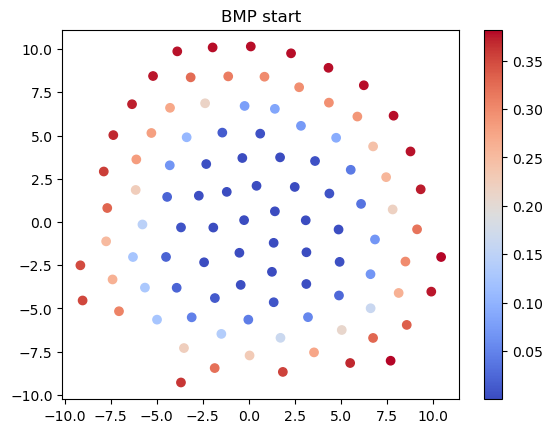

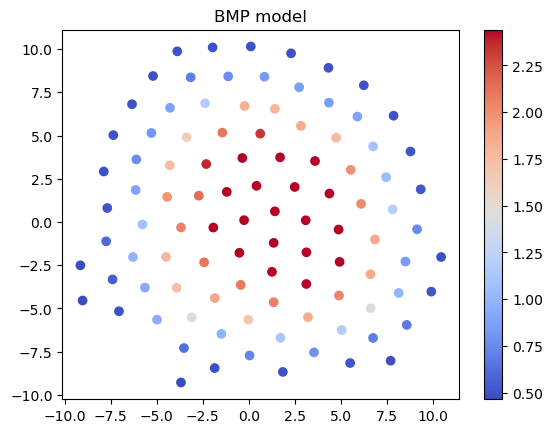

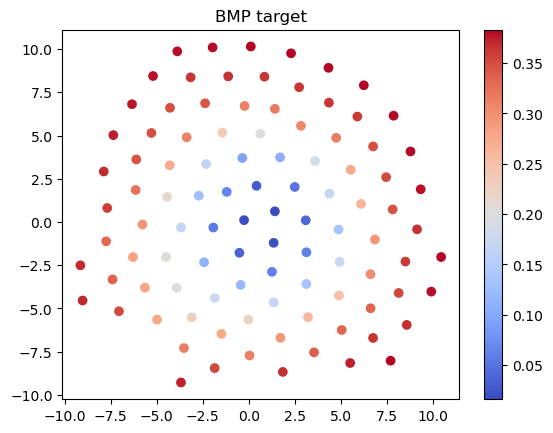

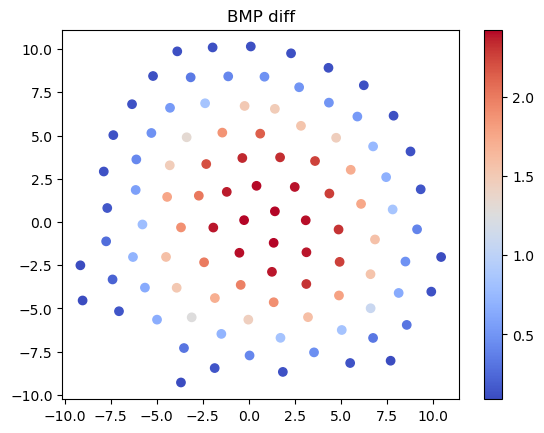

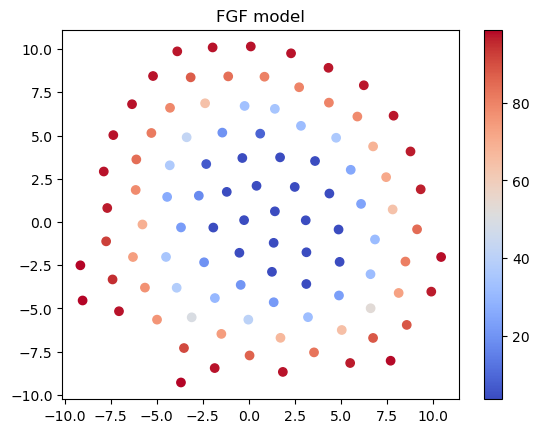

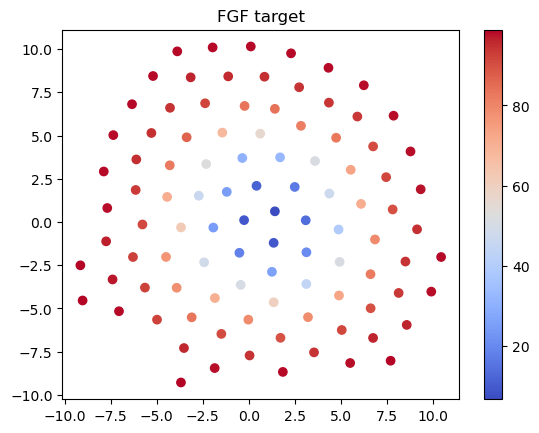

In [11]:
model.train(False)

# y_val = np.array([np.load(f'data/quarter_3_both.csv_BMP_levels.npy'), np.load(f'data/quarter_3_both.csv_FGF_levels.npy')])
y_val = env.ys[2]


iii = 50
print(y_val.shape)
X = torch.tensor(y_val[iii], dtype=torch.float32)
target = torch.tensor(y_val[iii+50] , dtype=torch.float32)

edges, edge_weights, border = env.get_edges(env.positions)

X = torch.cat((X, border.unsqueeze(1)), dim = 1)

out = model(X, edges, edge_weights)

out = out.detach().numpy()


plt.scatter(env.positions[:,0], env.positions[:,1], c=X[:,0], cmap='coolwarm')
plt.colorbar()
plt.title('BMP start')
plt.show()

plt.scatter(env.positions[:,0], env.positions[:,1], c=out[:,0], cmap='coolwarm')
plt.colorbar()
plt.title('BMP model')
plt.show()


plt.scatter(env.positions[:,0], env.positions[:,1], c=target[:,0], cmap='coolwarm')
plt.colorbar()
plt.title('BMP target')
plt.show()

# plot diff

plt.scatter(env.positions[:,0], env.positions[:,1], c=out[:,0] - target[:,0].detach().numpy(), cmap='coolwarm')
plt.colorbar()
plt.title('BMP diff')
plt.show()



plt.scatter(env.positions[:,0], env.positions[:,1], c=out[:,1], cmap='coolwarm')
plt.colorbar()
plt.title('FGF model')
plt.show()


plt.scatter(env.positions[:,0], env.positions[:,1], c=target[:,1], cmap='coolwarm')
plt.colorbar()
plt.title('FGF target')
plt.show()



In [39]:
# access the weights

for name, param in model.named_parameters():  
    if not "weight" in name:
        continue
    print(name, "\n",param.data.shape)

layer1.lin_rel.weight 
 torch.Size([8, 2])
layer1.lin_root.weight 
 torch.Size([8, 2])
layer2.weight 
 torch.Size([8, 8])
layer3.weight 
 torch.Size([2, 8])
